In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

enem_sample = pd.read_csv("https://github.com/guilhermesilveira/enem-2018/blob/master/MICRODADOS_ENEM_2018_SAMPLE_43278.csv?raw=true")
columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
enem_scores = enem_sample[columns]
enem_scores.columns = ['natural_science', 'human_science', 'language_&_code', 'math', 'text_production']
print(enem_scores.shape)
enem_scores.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(137844, 5)


,natural_science,human_science,language_&_code,math,text_production
0,nan,nan,nan,nan,nan
1,523.10,671.30,661.60,738.00,680.00
2,409.20,531.70,389.00,438.10,600.00
3,452.30,505.50,448.50,544.90,400.00
4,nan,nan,nan,nan,nan


#### **Day 4 - Task 1**: If the candidate is not present, fill in a number: zero, average or median
###### PS: I choose to drop the lines with NaN (candidates not present) because the test is applied on the same day, causing an idea of false correlation (both 0)

In [ ]:
enem_scores_drop = enem_scores.dropna()
enem_scores_drop.head()

,natural_science,human_science,language_&_code,math,text_production
1,523.10,671.30,661.60,738.00,680.00
2,409.20,531.70,389.00,438.10,600.00
3,452.30,505.50,448.50,544.90,400.00
6,428.50,505.20,521.00,436.80,560.00
8,491.80,575.70,524.40,487.60,660.00


#### **Day 4 - Task 2**: If The correlation matrix (heat map) is ugly, shall we make it more beautiful?

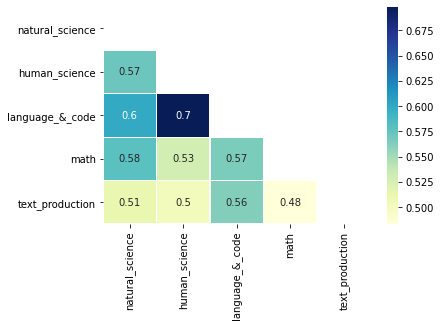

In [ ]:
corr = enem_scores_drop.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask, annot=True, linewidth=0.4, cmap="YlGnBu")

#### **Day 4 - Task 3**: Sketch the pairplot of the correct answers for each category. Use template (gabarito rs) and responses

In [ ]:
def count_corrects(row, subject):
  return sum(res == gab for (res, gab) in zip(row[f'TX_RESPOSTAS_{subject}'], row[f'TX_GABARITO_{subject}']))

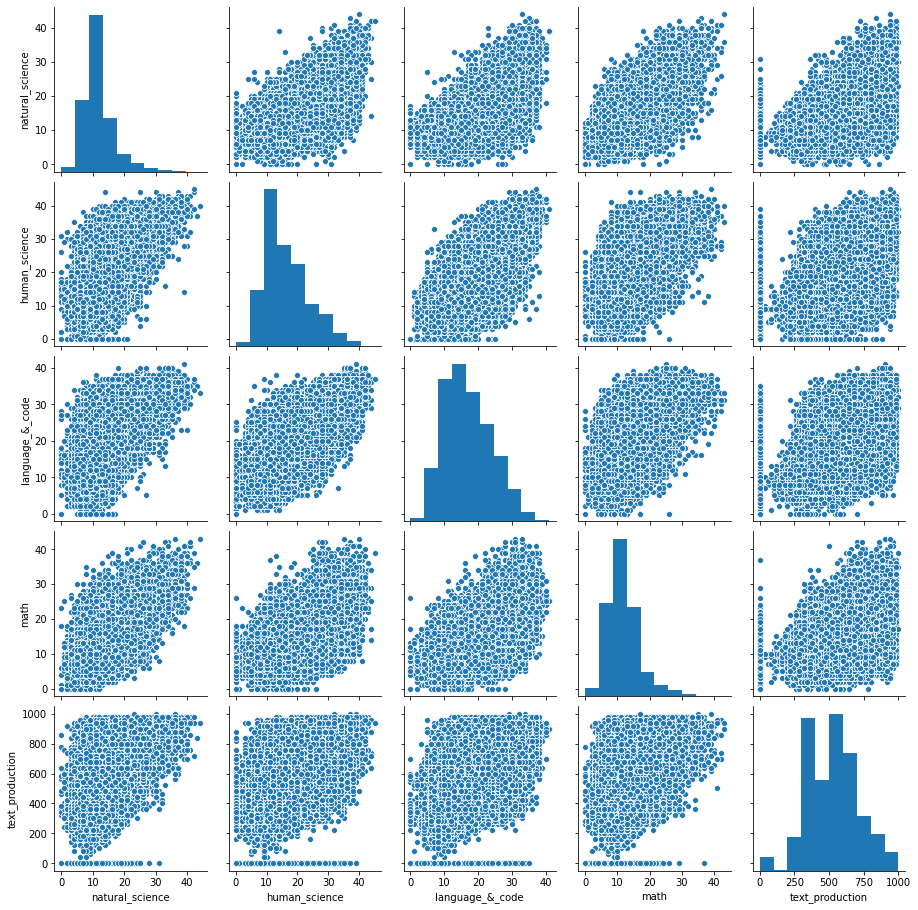

In [ ]:
enem_answers = enem_sample[['TX_RESPOSTAS_CN','TX_GABARITO_CN', 'TX_RESPOSTAS_CH','TX_GABARITO_CH', 'TX_RESPOSTAS_LC','TX_GABARITO_LC', 'TX_RESPOSTAS_MT','TX_GABARITO_MT', 'NU_NOTA_REDACAO']].dropna()

for item in ['CN', 'CH', 'LC', 'MT']:
  enem_answers[f'NU_CORRETAS_{item}'] = enem_answers.apply(count_corrects, subject=item, axis=1)

enem_answers = enem_answers[['NU_CORRETAS_CN','NU_CORRETAS_CH', 'NU_CORRETAS_LC','NU_CORRETAS_MT', 'NU_NOTA_REDACAO']]
enem_answers.columns = ['natural_science', 'human_science', 'language_&_code', 'math', 'text_production']
# enem_answers.head()
# enem_answers.corr()
sns.pairplot(enem_answers)

#### **Day 4 - Task 5** - Which questions had the most errors?
###### PS: Chosen book: Math (Gray, Code: 462) 

In [ ]:
def correction_inv(row):
  return ' '.join('0' if res == gab else '1' for (res, gab) in zip(row[f'TX_RESPOSTAS_MT'], row[f'TX_GABARITO_MT']))

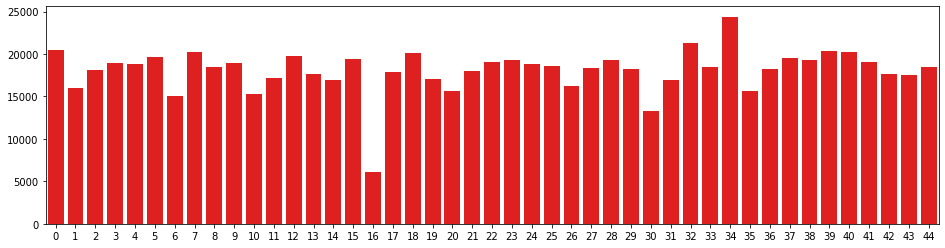

In [ ]:
questions = enem_sample.query('CO_PROVA_MT == 462')[['TX_RESPOSTAS_MT','TX_GABARITO_MT']].dropna()

questions['CORRECAO_MT_462'] = questions.apply(correction_inv, axis=1)  # Apply the correction -> output:'0 1 0 ... 1 0', Wrong: 1, Correct: 0
questions = questions['CORRECAO_MT_462'].str.split(expand=True)         # String above to 45 columns
questions = questions.apply(pd.to_numeric)                              # String to int values
questions = questions.sum(axis=0)                                       # Count the num of wrong answers in each question

sns.barplot(questions.index, questions.values, color='r')
plt.gcf().set_size_inches(16, 4)

#### **Day 5 - Task 1**: Explore the 'C' and 'max_iter' params of the LinearSVR model...

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVR


def SVR(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y)
  
  model = LinearSVR(C=2, max_iter=3000)
  model.fit(x_train, y_train)

  predict = model.predict(x_test)
  print(f'\n\n MSE: {mean_squared_error(predict, y_test)} \n\n')

  plt.figure(figsize=(9,9))
  sns.scatterplot(x=y_test.values, y=predict)
  return predict

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




 MSE: 4906.061607199073 




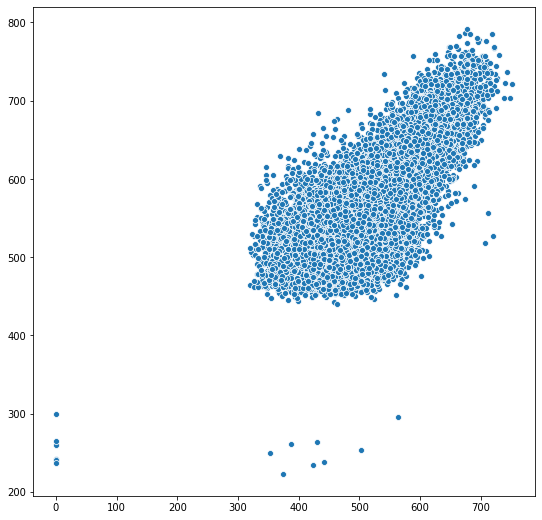

In [ ]:
enem_scores = enem_scores.dropna()

enem_scores_x = enem_scores[['natural_science', 'human_science', 'math', 'text_production']]
enem_scores_y = enem_scores['language_&_code']

predict_from_score = SVR(enem_scores_x, enem_scores_y)

#### **Day 5 - Task 2**: Use the average of the scores of the 4 tests as 'input entry' and plot the graph

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)




 MSE: 2644.0041377891685 




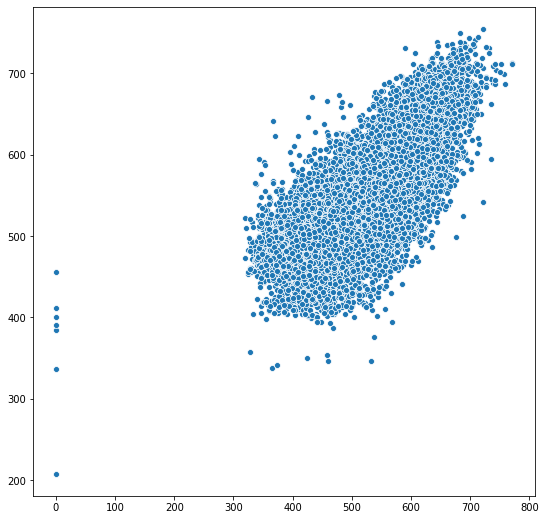

In [ ]:
enem_mean_x = pd.DataFrame(enem_scores_x.mean(axis=1))
predict_from_mean = SVR(enem_mean_x, enem_scores_y)

In [ ]:
''' 
  x (97270 rows) = natural_science, human_science, math, text_production 
    -> x_train 75% (72952 rows) 
    ->  x_test 25% (24318 rows)

  y = language_&_code
    -> y_train 75% (72952 rows) 
    ->  y_test 25% (24318 rows)
             _____________          _____________     _____________
  x_train -->|           |          |           |     |           |
             |   Model   |--------->|  Predict  |---->|  Compare  |<-- y_test
  y_train -->|___________|    +     |___________|     |___________|
                            x_test
'''
pd

<module 'pandas' from '/usr/local/lib/python3.6/dist-packages/pandas/__init__.py'>